# Init

In [1]:
%pip install matplotlib


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# imports
import gurobipy as gp
from gurobipy import GRB
from collections import defaultdict
import numpy as np
from collections import deque
import random
import copy as cp
import matplotlib.pyplot as plt

In [3]:
OPTIMAL_SOLUTION = 0 # used to evaluate gap between math model and heuristics

---
#### Load data

In [4]:
num_video = 0
num_endpoint = 0
num_req_descriptions = 0
num_server = 0

cache_capacity = 0
video_size = []

latency = defaultdict(lambda: defaultdict(int))     # [endpoint][cache/datacenter] = latency
reqs = defaultdict(lambda: defaultdict(int))        # [endpoint][video] = num reqs

# dataset = "dataset/videos_worth_spreading.in"
dataset = "dataset/me_at_the_zoo.in"
# dataset = "dataset/custom.in"
# dataset = "dataset/minimal.in"


In [5]:
status = 0
curr_endpoint_index = 0
num_connected_cache = 0
with open(dataset, "r") as f:
    for line_content in f:
        line = line_content.split()

        if status ==0:                                  # get counters
            num_video = int(line[0])
            num_endpoint = int(line[1])
            num_req_descriptions = int(line[2])
            num_server = int(line[3])
            cache_capacity = int(line[4])
            status = 1

        elif status == 1:                               # get video dims
            for size in line:
                video_size.append(int(size))
            status = 2

        elif status == 2:                               # get datacenter latency and connected cache number
            data_center_latency = int(line[0])
            latency[curr_endpoint_index][num_server] = data_center_latency
            
            num_connected_cache = int(line[1])
            if not num_connected_cache:
                curr_endpoint_index = curr_endpoint_index + 1
                if curr_endpoint_index == num_endpoint:
                    status = 4
            else:
                status = 3
        
        elif status == 3:                                  # get cache latency
            cache_index = int(line[0])
            cache_latency = int(line[1])
            latency[curr_endpoint_index][cache_index] = cache_latency
            
            num_connected_cache = num_connected_cache - 1
            if not num_connected_cache:
                curr_endpoint_index = curr_endpoint_index + 1
                if curr_endpoint_index == num_endpoint:
                    status = 4
                else:
                    status = 2
        
        elif status == 4:                                   # take num requests
            video_index = int(line[0])
            curr_endpoint_index = int(line[1])
            num_reqs = int(line[2])
            reqs[curr_endpoint_index][video_index] = num_reqs                         

In [6]:
# Common indexes
endpoint_index = range(num_endpoint)
server_index = range(num_server + 1) # I've modelled datacenter as last server
video_index = range(num_video)

In [7]:
print(f"num video: {num_video}, num endpoints {num_endpoint}, req descriptions {num_req_descriptions}, num cache {num_server}, dim {cache_capacity}")
print(f"video sized: {video_size}")
print(f"latencies: {latency}")
print(f"reqs: {reqs}")

num video: 100, num endpoints 10, req descriptions 100, num cache 10, dim 100
video sized: [20, 11, 50, 26, 5, 3, 6, 32, 40, 22, 4, 20, 50, 27, 49, 44, 1, 37, 35, 27, 14, 33, 6, 22, 23, 48, 44, 14, 26, 9, 46, 44, 15, 32, 31, 8, 39, 27, 39, 27, 1, 17, 1, 47, 44, 42, 16, 3, 44, 48, 5, 25, 4, 39, 39, 7, 24, 28, 14, 44, 22, 11, 27, 37, 11, 16, 50, 33, 22, 26, 7, 12, 17, 30, 12, 12, 4, 32, 12, 46, 43, 4, 12, 34, 11, 7, 47, 29, 24, 40, 41, 10, 5, 22, 22, 24, 37, 34, 50, 5]
latencies: defaultdict(<function <lambda> at 0x7f732ca8dee0>, {0: defaultdict(<class 'int'>, {10: 1013, 0: 170, 1: 22, 2: 224}), 1: defaultdict(<class 'int'>, {10: 696, 0: 7, 1: 50}), 2: defaultdict(<class 'int'>, {10: 1114, 1: 202, 4: 175, 5: 2}), 3: defaultdict(<class 'int'>, {10: 464, 1: 24, 8: 25}), 4: defaultdict(<class 'int'>, {10: 522, 3: 216, 5: 155, 6: 139, 7: 208, 8: 145}), 5: defaultdict(<class 'int'>, {10: 321, 0: 26, 2: 70, 8: 159, 9: 92}), 6: defaultdict(<class 'int'>, {10: 1288, 2: 163, 9: 153}), 7: defaultd

---
# Math model for Guroby

In [8]:
model = gp.Model("YoutubeCache")

# DECISION VARS
x = model.addVars(endpoint_index, server_index, video_index, vtype=gp.GRB.BINARY, name="x")
y = model.addVars(server_index, video_index, vtype=gp.GRB.BINARY, name="y")

# OBJECTIVE FUNCTION
obj = gp.quicksum(latency[e][s]*reqs[e][v]*x[e,s,v] for e in endpoint_index for s in server_index for v in video_index)
# the + y[s,v] it's used just to not let place useless video in cache server (but is not needed for this problem)
# obj = gp.quicksum((latency[e][s]*reqs[e][v]*x[e,s,v] + y[s,v])for e in endpoint_index for s in server_index for v in video_index)
model.setObjective(obj, GRB.MINIMIZE)


# CONSTRAINTS
constr = (gp.quicksum(x[e,s,v] for e in endpoint_index)  <= num_endpoint*y[s,v] for s in server_index for v in video_index )
model.addConstrs(constr, name="video v must be available on server s to be selected")

constr = ( gp.quicksum( x[e,s,v] for v in video_index ) <= (num_video*latency[e][s]) for e in endpoint_index for s in server_index[:-1] ) # -1 because datacenter have all the video
model.addConstrs(constr, name="endpoint can use only existing connection")

constr = ( gp.quicksum( x[e,s,v] for s in server_index ) == (1 if reqs[e][v] else 0) for e in endpoint_index for v in video_index ) # datacenter excluded 
model.addConstrs(constr, name="every request must be satisfied")

constr = ( gp.quicksum(video_size[v] * y[s,v] for v in video_index) <= cache_capacity for s in server_index[:-1] ) # -1 because datacenter have all the video
model.addConstrs(constr, name="cache capacity")

constr = ( y[num_server,v] == 1 for v in video_index ) # cache servers are from 0 to s-1, s index (num_server) is for datacenter
model.addConstrs(constr, name="Datacenter have all videos")


Set parameter Username
Set parameter LicenseID to value 2635449
Academic license - for non-commercial use only - expires 2026-03-12
Error: invalid user locale; possible fix is to set the system environment
       variable 'LC_ALL' to a valid locale (e.g., to 'C')


{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>

In [9]:
# Optimize the model
model.optimize()

# model.display()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Arch Linux")

CPU model: AMD Ryzen 7 5700U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 2310 rows, 12100 columns and 34200 nonzeros
Model fingerprint: 0x8ed62ee6
Variable types: 0 continuous, 12100 integer (12100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [2e+02, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+04]
Found heuristic solution: objective 1.172420e+07
Presolve removed 2169 rows and 11778 columns
Presolve time: 0.02s
Presolved: 141 rows, 322 columns, 633 nonzeros
Variable types: 0 continuous, 322 integer (322 binary)
Found heuristic solution: objective 8551097.0000

Root relaxation: objective 3.127974e+06, 126 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj

In [10]:
# Print model output

def print_full_output():
    print("Optimal X [endpoint, server, video] values:")
    for e in endpoint_index:
        for s in server_index:
            for v in video_index:
                print(f"X[{e},{s},{v}] * {latency[e][s]} = {x[e,s,v]}")
    print("\nOptimal Y [server, video] values:")
    for s in server_index:
        for v in video_index:
            print(f"Y[{s},{v}] = {y[s,v]}")

def print_concise_output():
    print("Optimal X [endpoint, server, video] values:")
    for e in endpoint_index:
        for s in server_index:
            for v in video_index:
                if x[e,s,v].x:
                    print(f"X[{e},{s},{v}] * {latency[e][s]} = {x[e,s,v]}")
    print("\nOptimal Y [server, video] values:")
    for s in server_index:
        for v in video_index:
            if y[s,v].x:
                print(f"Y[{s},{v}] = {y[s,v]}")

In [11]:
# results
if model.status == gp.GRB.OPTIMAL:
    print("\nOptimization successful!")
    # print_full_output()
    print_concise_output()
    print(f"\nOptimal objective value: {model.objVal}")
    OPTIMAL_SOLUTION = model.ObjVal
elif model.status == gp.GRB.INFEASIBLE:
    print("Model is infeasible.")
elif model.status == gp.GRB.UNBOUNDED:
    print("Model is unbounded.")
else:
    print(f"Optimization ended with status {model.status}")


Optimization successful!
Optimal X [endpoint, server, video] values:
X[0,0,7] * 170 = <gurobi.Var x[0,0,7] (value 1.0)>
X[0,0,31] * 170 = <gurobi.Var x[0,0,31] (value 1.0)>
X[0,1,1] * 22 = <gurobi.Var x[0,1,1] (value 1.0)>
X[0,1,15] * 22 = <gurobi.Var x[0,1,15] (value 1.0)>
X[0,1,65] * 22 = <gurobi.Var x[0,1,65] (value 1.0)>
X[0,1,99] * 22 = <gurobi.Var x[0,1,99] (value 1.0)>
X[0,2,8] * 224 = <gurobi.Var x[0,2,8] (value 1.0)>
X[0,2,13] * 224 = <gurobi.Var x[0,2,13] (value 1.0)>
X[0,10,26] * 1013 = <gurobi.Var x[0,10,26] (value 1.0)>
X[1,0,5] * 7 = <gurobi.Var x[1,0,5] (value 1.0)>
X[1,0,7] * 7 = <gurobi.Var x[1,0,7] (value 1.0)>
X[1,0,10] * 7 = <gurobi.Var x[1,0,10] (value 1.0)>
X[1,0,46] * 7 = <gurobi.Var x[1,0,46] (value 1.0)>
X[1,1,0] * 50 = <gurobi.Var x[1,1,0] (value 1.0)>
X[1,1,1] * 50 = <gurobi.Var x[1,1,1] (value 1.0)>
X[1,10,89] * 696 = <gurobi.Var x[1,10,89] (value 1.0)>
X[2,4,8] * 175 = <gurobi.Var x[2,4,8] (value 1.0)>
X[2,4,17] * 175 = <gurobi.Var x[2,4,17] (value 1.0)>
X

---
# Heuristics

In [12]:
## Common
def compute_obj_func(x):
    return sum(latency[e][s]*reqs[e][v]*x[e,s,v] for e in endpoint_index for s in server_index for v in video_index)

x_sol = [] # save X matrix of greedy's solution to use it later in tabu search
y_sol = [] # same for Y matrix

## Greedy

### 1
order videos by request number, and for every endpoint retrieven from this ordered list place all its requested videos in best available caches for it

In [13]:
E_IND = 0
V_IND = 1

# Sort v indexes by descending value for endpoint e
sorted_reqs = []
for e in range(len(reqs)):
    sorted_vs = sorted(
        [v for v in reqs[e] if reqs[e][v] != 0],
        key=lambda v: reqs[e][v],
        reverse=True
    )
    sorted_reqs.extend((e, v) for v in sorted_vs)

# Sort server s latency for endpoint e
sorted_latency = defaultdict(list)
for e in latency:
    sorted_s = sorted(
        [s for s in latency[e] if latency[e][s] != 0],
        key=lambda s: latency[e][s]
    )
    sorted_latency[e] = sorted_s


# use a list to keep current cache capacity (will be decreased every time a video is placed in cache)
curr_capacity = [cache_capacity for _ in range(num_server)]
curr_capacity.append(float('inf')) # datacenter doesn't have capacity

# create vars (simil guroby, used numpy for efficiency)
x = np.zeros((num_endpoint, (num_server+1), num_video)) 
y = np.zeros(((num_server+1), num_video)) 
y[num_server, :] = 1 # datacenter keep all the videos

for req in sorted_reqs:
    req_endpoint = req[E_IND]
    req_video = req[V_IND]
    req_video_size = video_size[req_video]

    for curr_cache_index in sorted_latency[req_endpoint]:
        if y[curr_cache_index, req_video]:
            x[req_endpoint, curr_cache_index, req_video] = 1
            break
        else:
            if curr_capacity[curr_cache_index] > req_video_size:
                curr_capacity[curr_cache_index] -= req_video_size
                y[curr_cache_index, req_video] = 1
                x[req_endpoint, curr_cache_index, req_video] = 1
                break

# print("X")
# print(x)
# print("Y")
# print(y)
APPROX_RESULT = compute_obj_func(x)
GAP = ( abs(OPTIMAL_SOLUTION - APPROX_RESULT) / OPTIMAL_SOLUTION ) * 100
print(f"APPROX RESULT: {APPROX_RESULT} - GAP: {GAP}% - OPTIMAL RESULT {OPTIMAL_SOLUTION}")
x_sol.append((x, APPROX_RESULT))
y_sol.append((y, APPROX_RESULT))


APPROX RESULT: 6347627.0 - GAP: 47.86207021857758% - OPTIMAL RESULT 4292938.0


### 2
order videos by request number, use a round robin schedule to choose an endpoint retrieven from this ordered list and place its remaining requested video in best available cache

In [14]:
E_IND = 0
V_IND = 1

# Sort v indexes by descending value for endpoint e
sorted_reqs = defaultdict(list)
for e in range(len(reqs)):
    sorted_vs = sorted(
        [v for v in reqs[e] if reqs[e][v] != 0],
        key=lambda v: reqs[e][v],
        reverse=True
    )
    sorted_reqs[e] = sorted_vs

# Sort server s latency for endpoint e
sorted_latency = defaultdict(list)
for e in latency:
    sorted_s = sorted(
        [s for s in latency[e] if latency[e][s] != 0],
        key=lambda s: latency[e][s]
    )
    sorted_latency[e] = sorted_s


# use a list to keep current cache capacity (will be decreased every time a video is placed in cache)
curr_capacity = [cache_capacity for _ in range(num_server)]
curr_capacity.append(float('inf')) # datacenter doesn't have capacity

# create vars (simil guroby, used numpy for efficiency)
x = np.zeros((num_endpoint, (num_server+1), num_video))
y = np.zeros(((num_server+1), num_video))
y[num_server, :] = 1 # datacenter keep all the videos

Done = False
endpoints_req_index = [0 for _ in server_index]
while not Done:
    Done = True
    for curr_endpoint in endpoint_index:
        curr_endpoint_req_index = endpoints_req_index[curr_endpoint]
        
        if curr_endpoint_req_index < len(sorted_reqs[curr_endpoint]):
            Done = False # There could still be reqs not satisfied other than this
            req_video = sorted_reqs[curr_endpoint][curr_endpoint_req_index]
            req_video_size = video_size[req_video]

            for curr_cache_index in sorted_latency[curr_endpoint]:
                if y[curr_cache_index, req_video]:
                    x[curr_endpoint, curr_cache_index, req_video] = 1
                    break
                else:
                    if curr_capacity[curr_cache_index] > req_video_size:
                        curr_capacity[curr_cache_index] -= req_video_size
                        y[curr_cache_index, req_video] = 1
                        x[curr_endpoint, curr_cache_index, req_video] = 1
                        break
                    
        endpoints_req_index[curr_endpoint] += 1

# print("X")
# print(x)
# print("Y")
# print(y)
APPROX_RESULT = compute_obj_func(x)
GAP = ( abs(OPTIMAL_SOLUTION - APPROX_RESULT) / OPTIMAL_SOLUTION ) * 100
print(f"APPROX RESULT: {APPROX_RESULT} - GAP: {GAP}% - OPTIMAL RESULT {OPTIMAL_SOLUTION}")
x_sol.append((x, APPROX_RESULT))
y_sol.append((y, APPROX_RESULT))


APPROX RESULT: 7091338.0 - GAP: 65.18612661072673% - OPTIMAL RESULT 4292938.0


### 3
order videos by request number without considering the endpoints, place them in the best available cache server for the requester endpoint

In [15]:
E_IND = 0
V_IND = 1

# Sort v indexes by descending value for endpoint e
sorted_reqs = []
sorted_reqs = sorted(
    [(e, v) for e in range(len(reqs)) for v in reqs[e] if reqs[e][v] != 0],
    key=lambda pair: reqs[pair[0]][pair[1]],
    reverse=True
)

# Sort server s latency for endpoint e
sorted_latency = defaultdict(list)
for e in latency:
    sorted_s = sorted(
        [s for s in latency[e] if latency[e][s] != 0],
        key=lambda s: latency[e][s]
    )
    sorted_latency[e] = sorted_s


# use a list to keep current cache capacity (will be decreased every time a video is placed in cache)
curr_capacity = [cache_capacity for _ in range(num_server)]
curr_capacity.append(float('inf')) # datacenter doesn't have capacity

# create vars (simil guroby, used numpy for efficiency)
x = np.zeros((num_endpoint, (num_server+1), num_video))
y = np.zeros(((num_server+1), num_video))
y[num_server, :] = 1 # datacenter keep all the videos

for req_endpoint,req_video in sorted_reqs:
    req_video_size = video_size[req_video]

    for curr_cache_index in sorted_latency[req_endpoint]:
        if y[curr_cache_index, req_video]:
            x[req_endpoint, curr_cache_index, req_video] = 1
            break
        else:
            if curr_capacity[curr_cache_index] > req_video_size:
                curr_capacity[curr_cache_index] -= req_video_size
                y[curr_cache_index, req_video] = 1
                x[req_endpoint, curr_cache_index, req_video] = 1
                break

# print("X")
# print(x)
# print("Y")
# print(y)
APPROX_RESULT = compute_obj_func(x)
GAP = ( abs(OPTIMAL_SOLUTION - APPROX_RESULT) / OPTIMAL_SOLUTION ) * 100
print(f"APPROX RESULT: {APPROX_RESULT} - GAP: {GAP}% - OPTIMAL RESULT {OPTIMAL_SOLUTION}")
x_sol.append((x, APPROX_RESULT))
y_sol.append((y, APPROX_RESULT))


APPROX RESULT: 6776093.0 - GAP: 57.842787387099456% - OPTIMAL RESULT 4292938.0


### 4
order videos by request number, place them in the cache connected with most endpoints that have requested that specific video

In [16]:
video_req_count = [0 for _ in video_index]
num_connected_endpoint = defaultdict(lambda: defaultdict(int)) # used to find best cache to place a video [server][video][latency sum / num endpoint / score]

for curr_endpoint_index, endpoint_reqs in reqs.items():
    for curr_video_index, req_num in endpoint_reqs.items():
        if req_num: # check if requests from endpoint for the video exists
            video_req_count[curr_video_index] += req_num
            for curr_server_index, lat in latency[curr_endpoint_index].items():
                if curr_server_index != num_server and lat:
                    num_connected_endpoint[curr_server_index][curr_video_index] += 1
            
sorted_video_indexes = sorted(range(num_video), key=lambda i: video_req_count[i], reverse=True)

# use a list to keep current cache capacity (will be decreased every time a video is placed in cache)
curr_capacity = [cache_capacity for _ in range(num_server)]
curr_capacity.append(float('inf')) # datacenter doesn't have capacity
# print(curr_capacity)

# create vars (simil guroby, used numpy for efficiency)
x = np.zeros((num_endpoint, (num_server+1), num_video)) # e take v from s
y = np.zeros(((num_server+1), num_video)) # v is in s
y[num_server, :] = 1 # datacenter keep all the videos

# Sort server s latency for endpoint e
sorted_latency = defaultdict(list)
for e in latency:
    # Sort v indices by ascending value for this e
    sorted_s = sorted(
        [s for s in latency[e] if latency[e][s] != 0],
        key=lambda s: latency[e][s]
    )
    sorted_latency[e] = sorted_s


for curr_video_index in sorted_video_indexes:
    # now sort caches to get the ones with most connected endpoints that have requested video: curr_video_index
    for curr_server_index in sorted(
        [
            i
            for i in range(len(num_connected_endpoint))
            if num_connected_endpoint[i][curr_video_index]!= 0
        ],
        key=lambda i: num_connected_endpoint[i][curr_video_index],
        reverse=True
    ):
        if not y[curr_server_index, curr_video_index]:
            if curr_capacity[curr_server_index] > video_size[curr_video_index]:
                curr_capacity[curr_server_index] -= video_size[curr_video_index]
                y[curr_server_index, curr_video_index] = 1
                break

# iterate trough all reqs to check to what server the endpoint should request the video
for req_endpoint,req_videos in reqs.items():    
    for curr_video_index in req_videos:
        if reqs[req_endpoint][curr_video_index]:
            for curr_server_index in sorted_latency[req_endpoint]:
                if y[curr_server_index, curr_video_index]:
                    x[req_endpoint, curr_server_index, curr_video_index] = 1
                    break

# print("X")
# print(x)
# print("Y")
# print(y)
APPROX_RESULT = compute_obj_func(x)
GAP = ( abs(OPTIMAL_SOLUTION - APPROX_RESULT) / OPTIMAL_SOLUTION ) * 100
print(f"APPROX RESULT: {APPROX_RESULT} - GAP: {GAP}% - OPTIMAL RESULT {OPTIMAL_SOLUTION}")
x_sol.append((x, APPROX_RESULT))
y_sol.append((y, APPROX_RESULT))


APPROX RESULT: 9816241.0 - GAP: 128.66020892917624% - OPTIMAL RESULT 4292938.0


### 5
iterate trough every cache, place their most requested video from connected endpoints

In [17]:
E_IND = 0
V_IND = 1

# Sort server s latency for endpoint e
sorted_latency = defaultdict(list)
for e in latency:
    sorted_s = sorted(
        [s for s in latency[e] if latency[e][s] != 0],
        key=lambda s: latency[e][s]
    )
    sorted_latency[e] = sorted_s


# use a list to keep current cache capacity (will be decreased every time a video is placed in cache)
curr_capacity = [cache_capacity for _ in range(num_server)]
curr_capacity.append(float('inf')) # datacenter doesn't have capacity

# create vars (simil guroby, used numpy for efficiency)
x = np.zeros((num_endpoint, (num_server+1), num_video)) # e take v from s
y = np.zeros(((num_server+1), num_video)) # v is in s
y[num_server, :] = 1 # datacenter keep all the videos


# get total possible reqs for any cache server from its connected endpoints
server_total_reqs = defaultdict(lambda: defaultdict(int))
for req_endpoint,req_videos in reqs.items():
    for curr_server_index, lat in latency[req_endpoint].items():
                if curr_server_index != num_server and lat:
                    for curr_video_index in req_videos.keys():
                        server_total_reqs[curr_server_index][curr_video_index] += req_videos[curr_video_index]


# place video in caches based on request counts
for curr_server_index in server_index[:-1]:
    sorted_indexes_only = [
        video_index
        for video_index, count in sorted(
            server_total_reqs[curr_server_index].items(),
            key=lambda x: x[1],
            reverse=True
        )
        if count > 0
    ]
    for curr_video_index in sorted_indexes_only:
        if not y[curr_server_index, curr_video_index] and curr_capacity[curr_server_index] > video_size[curr_video_index]:
            curr_capacity[curr_server_index] -= video_size[curr_video_index]
            y[curr_server_index, curr_video_index] = 1


# iterate trough all reqs to check to what server the endpoint should request the video
for req_endpoint,req_videos in reqs.items():    
    for curr_video_index in req_videos:
        if reqs[req_endpoint][curr_video_index]:
            for curr_server_index in sorted_latency[req_endpoint]:
                if y[curr_server_index, curr_video_index]:
                    x[req_endpoint, curr_server_index, curr_video_index] = 1
                    break

# print("X")
# print(x)
# print("Y")
# print(y)
APPROX_RESULT = compute_obj_func(x)
GAP = ( abs(OPTIMAL_SOLUTION - APPROX_RESULT) / OPTIMAL_SOLUTION ) * 100
print(f"APPROX RESULT: {APPROX_RESULT} - GAP: {GAP}% - OPTIMAL RESULT {OPTIMAL_SOLUTION}")
x_sol.append((x, APPROX_RESULT))
y_sol.append((y, APPROX_RESULT))

APPROX RESULT: 9519517.0 - GAP: 121.74829918344965% - OPTIMAL RESULT 4292938.0


## Local Search

### tabu search

In [18]:
# satisfy endpoints request considering the video placements from passed Y matrix
def get_best_x(y):
    x = np.zeros((num_endpoint, (num_server+1), num_video))

    # Sort server s latency for endpoint e
    sorted_latency = defaultdict(list)
    for e in latency:
        sorted_s = sorted(
            [s for s in latency[e] if latency[e][s] != 0],
            key=lambda s: latency[e][s]
        )
        sorted_latency[e] = sorted_s
    
    for curr_endpoint_index in endpoint_index:
        for curr_video_index in reqs[curr_endpoint_index]:
            best_server_index = num_server  # default to datacenter
            
            for curr_server_index in sorted_latency[curr_endpoint_index]:                    
                if y[curr_server_index][curr_video_index]:
                    best_server_index = curr_server_index
                    break

            x[curr_endpoint_index][best_server_index][curr_video_index] = 1

    return x

In [19]:
def tabu_search_toggle(x, y, num_iters=1000, tabu_list_dim=10, max_no_improve=100):
    tabu_list = deque(maxlen=tabu_list_dim)
    intensification_list = []
    
    # Start with initial solution
    best_x = np.copy(x)
    best_y = np.copy(y)
    best_obj_val = compute_obj_func(best_x)
    no_improve_count = 0  
    
    for iteration in range(num_iters):
        neighborhood = []

        # Generate neighbor solutions
        for curr_server_index in server_index[:-1]:  # Only cache servers
            for curr_video_index in video_index:
                move = (curr_server_index, curr_video_index)
                
                if move in tabu_list:
                    # ASPIRATION CRITERIA    
                    if random.random() > 0.2:
                        continue

                # Try toggling video v in cache s
                new_y = np.copy(y)
                new_y[curr_server_index][curr_video_index] = 1 - new_y[curr_server_index][curr_video_index]

                # Check cache capacity constraint
                curr_video_size = sum(video_size[v] for v in video_index if new_y[curr_server_index][v])
                if curr_video_size > cache_capacity:
                    continue

                # Generate new x according to new y
                new_x = get_best_x(new_y)

                obj_val = compute_obj_func(new_x)

                neighborhood.append((obj_val, new_x, new_y, move))

        if not neighborhood:
            break

        # Choose best neighbor
        neighborhood.sort(key=lambda tup: tup[0])  # Sort by delay
        obj_val, new_x, new_y, move = neighborhood[0]

        if obj_val < best_obj_val:
            best_obj_val = obj_val
            best_x = new_x
            best_y = new_y
            intensification_list.append((best_obj_val, best_x, best_y))
            intensification_list = sorted(intensification_list)[:10]  # keep top 10
            no_improve_count = 0 # reset no consecutive improvement counter
        else:
            no_improve_count += 1
            
        if no_improve_count >= max_no_improve:
            print(f"Early stopping after {no_improve_count} iterations without improvement.")
            break
        
        # Update current solution
        x = new_x
        y = new_y

        # Update tabu list
        tabu_list.append(move)
        
        # INTENSIFICATION CRITERIA
        if iteration % 70 == 0 and intensification_list:
            _, best_x, best_y = random.choice(intensification_list)
            x, y = best_x.copy(), best_y.copy()

    return best_x, best_y, best_obj_val

In [20]:
def tabu_search_add(x, y, num_iters=1000, tabu_list_dim=10, max_no_improve=100):
    tabu_list = deque(maxlen=tabu_list_dim)
    intensification_list = []
    
    # Start with initial solution
    best_x = np.copy(x)
    best_y = np.copy(y)
    best_obj_val = compute_obj_func(best_x)
    no_improve_count = 0  
    
    for iteration in range(num_iters):
        neighborhood = []

        # Generate neighbor solutions
        for curr_server_index in server_index[:-1]:  # Only cache servers
            for curr_video_index in video_index:
                move = (curr_server_index, curr_video_index)
                
                if move in tabu_list:
                    # ASPIRATION CRITERIA    
                    if random.random() > 0.2:
                        continue
                    

                # Try toggling video v in cache s
                new_y = np.copy(y)
                
                # Try adding current video in current server if not already present
                if new_y[curr_server_index][curr_video_index]:
                    continue
                new_y[curr_server_index][curr_video_index] = 1 

                # Check cache capacity constraint
                curr_video_size = sum(video_size[v] for v in video_index if new_y[curr_server_index][v])
                if curr_video_size > cache_capacity:
                    continue

                # Generate new x according to new y
                new_x = get_best_x(new_y)

                obj_val = compute_obj_func(new_x)

                neighborhood.append((obj_val, new_x, new_y, move))

        if not neighborhood:
            break

        # Choose best neighbor
        neighborhood.sort(key=lambda tup: tup[0])  # Sort by delay
        obj_val, new_x, new_y, move = neighborhood[0]

        if obj_val < best_obj_val:
            best_obj_val = obj_val
            best_x = new_x
            best_y = new_y
            intensification_list.append((best_obj_val, best_x, best_y))
            intensification_list = sorted(intensification_list)[:10]  # keep top 10
            no_improve_count = 0 # reset no consecutive improvement counter
        else:
            no_improve_count += 1
            
        if no_improve_count >= max_no_improve:
            print(f"Early stopping after {no_improve_count} iterations without improvement.")
            break

        # Update current solution
        x = new_x
        y = new_y

        # Update tabu list
        tabu_list.append(move)
        
        # INTENSIFICATION CRITERIA
        if iteration % 70 == 0 and intensification_list:
            _, best_x, best_y = random.choice(intensification_list)
            x, y = best_x.copy(), best_y.copy()

    return best_x, best_y, best_obj_val

In [21]:
print(f"best sol: {OPTIMAL_SOLUTION}")
tabu_list_dim = np.floor(np.sqrt(num_req_descriptions))

for sol_index in range(len(x_sol)):
    default_obj_val = compute_obj_func(x_sol[sol_index][0])
    GAP_DEF = ( abs(OPTIMAL_SOLUTION - default_obj_val) / OPTIMAL_SOLUTION ) * 100

    
    x_tabu_toggle, y_tabu_toggle, obj_tabu_toggle = tabu_search_toggle(x_sol[sol_index][0], y_sol[sol_index][0], num_iters=700, tabu_list_dim=int(tabu_list_dim))
    GAP_TOGGLE = ( abs(OPTIMAL_SOLUTION - obj_tabu_toggle) / OPTIMAL_SOLUTION ) * 100
    print(f"\nold solution: {default_obj_val}, tabu toggle sol: {obj_tabu_toggle}, new GAP: {GAP_TOGGLE}")
    
    x_tabu_add, y_tabu_add, obj_tabu_add = tabu_search_add(x_sol[sol_index][0], y_sol[sol_index][0], num_iters=700, tabu_list_dim=int(tabu_list_dim))
    GAP_ADD = ( abs(OPTIMAL_SOLUTION - obj_tabu_add) / OPTIMAL_SOLUTION ) * 100
    print(f"old solution: {default_obj_val}, tabu add sol: {obj_tabu_add}, new GAP: {GAP_ADD}")
    
    if obj_tabu_toggle < obj_tabu_add:
        if obj_tabu_toggle < default_obj_val:
            x_sol.append((x_tabu_toggle, obj_tabu_toggle))
            y_sol.append((y_tabu_toggle, obj_tabu_toggle))
    else:
        if obj_tabu_add < default_obj_val:
            x_sol.append((x_tabu_add, obj_tabu_add))
            y_sol.append((y_tabu_add, obj_tabu_add))

best sol: 4292938.0
Early stopping after 100 iterations without improvement.

old solution: 6347627.0, tabu toggle sol: 6347627.0, new GAP: 47.86207021857758
old solution: 6347627.0, tabu add sol: 6347627.0, new GAP: 47.86207021857758
Early stopping after 100 iterations without improvement.

old solution: 7091338.0, tabu toggle sol: 7091338.0, new GAP: 65.18612661072673
old solution: 7091338.0, tabu add sol: 7091338.0, new GAP: 65.18612661072673
Early stopping after 100 iterations without improvement.

old solution: 6776093.0, tabu toggle sol: 6776093.0, new GAP: 57.842787387099456
old solution: 6776093.0, tabu add sol: 6776093.0, new GAP: 57.842787387099456
Early stopping after 100 iterations without improvement.

old solution: 9816241.0, tabu toggle sol: 7161592.0, new GAP: 66.82262823269286
old solution: 9816241.0, tabu add sol: 7275848.0, new GAP: 69.48411554045272
Early stopping after 100 iterations without improvement.

old solution: 9519517.0, tabu toggle sol: 9013457.0, new GAP

## Genetic algorithm

#### fitness: minimize delay ( compute_obj_func(x) )
#### initial population: heuristics solutions (x_sol & y_sol)
#### randomization: montecarlo simulation
#### crossover & mutation: on y (update x conseguently get_best_x(y) )

In [29]:
best_start = min(x_sol, key=lambda solution: solution[1])
best_in_generation_history = [best_start[1]]

In [30]:
X_IND = 0
Y_IND = 1
OBJ_IND = 2

NUM_GEN = 400
NUM_CROSSOVER_TRIAL = 60
NUM_DEAD = 3
MUT_RATE = 0.001

# check if capacity of any cache is exceeded
def is_feasible(y):
    for curr_server_index in server_index[:-1]:
        curr_tot_size = sum(video_size[curr_video_index] for curr_video_index in video_index if y[curr_server_index, curr_video_index])
        if curr_tot_size > cache_capacity:
            return False
    return True

def montecarlo_roulette_individual_selection(current_population, reverse=False):
    # Reverse = True: dead selection - Reverse = False: parent selection
    if reverse:
        fitness_list = [ curr_individual[OBJ_IND] for curr_individual in current_population ]
    else:
        # 1 / obj func because less delay must have bigger probility
        fitness_list = [ (1/curr_individual[OBJ_IND]) for curr_individual in current_population ]
        
    fitness_tot = sum(fitness_list)
    
    spin = random.uniform(0, fitness_tot)
    
    curr_fit = 0
    for curr_individual_index in range(len(current_population)):
        curr_fit += fitness_list[curr_individual_index]
        if spin < curr_fit:
            
            if reverse:
                return curr_individual_index
            
            return current_population[curr_individual_index]

def crossover(parent1, parent2):
    # we need to clone parent or python will reference to them (and if we do mutation we'll do it also on parents)
    y1 = parent1[Y_IND].copy()
    y2 = parent2[Y_IND].copy()
    
    childs_y = []
    childs = []
    
    # Monosplit crossover
    split = np.random.randint(1, num_server)
    # take y cache configuration [0 to split] from parent 1 and remaining cache configuration [split to num_server+1] from parent2 
    childs_y.append( np.vstack([y1[:split, :], y2[split:, :]]) )
    childs_y.append( np.vstack([y1[:split, :], y2[split:, :]]) )
    
    for child_y in childs_y:
        child_x = get_best_x(child_y)
        childs.append((child_x, child_y, compute_obj_func(child_x)))
    
    return childs

def mutate(childs):

    childs_mutated = []
    
    for child in childs:
        child_mutated = cp.deepcopy(child)
        
        for curr_server_index in server_index[:-1]:
            for curr_video_index in video_index:
                
                # mutation is a toggle in y matrix
                if random.random() < MUT_RATE:
                    child_mutated[Y_IND][curr_server_index][curr_video_index] = 1 - child_mutated[Y_IND][curr_server_index][curr_video_index] 
        
        # check if mutated child is feasible, otherwise keep unmutated one
        if is_feasible(child_mutated[Y_IND]):
            childs_mutated.append(child_mutated)                    
        else:
            childs_mutated.append(child)                    
            
    return childs_mutated

def start_genetic():
    # an individual is (x, y, objective value)
    population = [(x_sol[curr_individual_index][0], y_sol[curr_individual_index][0], x_sol[curr_individual_index][1]) for curr_individual_index in range(len(y_sol))]
    # print(f"Starting population: {population}")
    
    for current_gen in range(NUM_GEN):
        if population:
            for _ in range(NUM_CROSSOVER_TRIAL): 
                parent_1 = montecarlo_roulette_individual_selection(population)
                parent_2 = montecarlo_roulette_individual_selection(population)
                childs = crossover(parent_1, parent_2)
                childs = mutate(childs)
                if childs:
                    population.extend(childs)
            
            # remove an individual every iteration
            # for _ in range(NUM_DEAD):
            serial_killer_num = len(population) // 10 # floor of 10% of population
            for _ in range(serial_killer_num):
                dead = montecarlo_roulette_individual_selection(population, reverse=True)
                tomb = population.pop(dead)
                
            if population:
                # print(f"Death individual: {dead} - {tomb}")
                best = min(population, key=lambda individual: individual[OBJ_IND])
                best_in_generation_history.append(best[OBJ_IND])
                print(f"Gen {current_gen}: Best delay = {best[OBJ_IND]}")
        else:
            return "GENOCIDE"
        
        
    return min(population, key=lambda individual: individual[OBJ_IND])

sol = start_genetic()
best_in_generation_history.append(sol[OBJ_IND])
print(f"{sol}")


Gen 0: Best delay = 5899138.0
Gen 1: Best delay = 6363652.0
Gen 2: Best delay = 6315358.0
Gen 3: Best delay = 6315358.0
Gen 4: Best delay = 6315358.0
Gen 5: Best delay = 6315358.0
Gen 6: Best delay = 6315358.0
Gen 7: Best delay = 6013168.0
Gen 8: Best delay = 6013168.0
Gen 9: Best delay = 6013168.0
Gen 10: Best delay = 6013168.0
Gen 11: Best delay = 6013168.0
Gen 12: Best delay = 6013168.0
Gen 13: Best delay = 6013168.0
Gen 14: Best delay = 6013168.0
Gen 15: Best delay = 6013168.0
Gen 16: Best delay = 6013168.0
Gen 17: Best delay = 5985708.0
Gen 18: Best delay = 5706798.0
Gen 19: Best delay = 5706798.0
Gen 20: Best delay = 5706798.0
Gen 21: Best delay = 5706798.0
Gen 22: Best delay = 5706798.0
Gen 23: Best delay = 5706798.0
Gen 24: Best delay = 5706798.0
Gen 25: Best delay = 5706798.0
Gen 26: Best delay = 5706798.0
Gen 27: Best delay = 5706798.0
Gen 28: Best delay = 5706798.0
Gen 29: Best delay = 5706798.0
Gen 30: Best delay = 5706798.0
Gen 31: Best delay = 5706798.0
Gen 32: Best delay

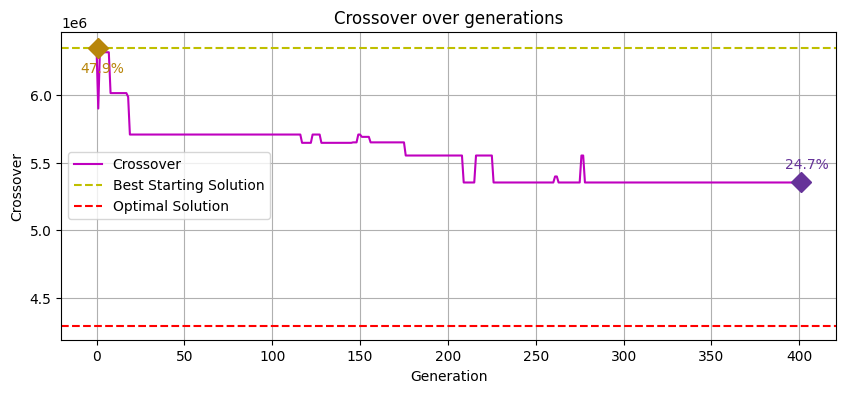

Genetic Solution GAP: 24.67454689538959


In [31]:
# PLOT performance
GAP = ( abs(OPTIMAL_SOLUTION - best_in_generation_history[-1]) / OPTIMAL_SOLUTION ) * 100
GAP_START = ( abs(OPTIMAL_SOLUTION - best_start[1]) / OPTIMAL_SOLUTION ) * 100

plt.figure(figsize=(10, 4))
plt.plot(best_in_generation_history, linestyle='-', color="m", label="Crossover")
plt.axhline(y=float(best_start[1]), linestyle='--', color="y", label="Best Starting Solution") 
plt.axhline(y=OPTIMAL_SOLUTION, color='r', linestyle='--', label='Optimal Solution')

# best solution GAP
plt.plot(len(best_in_generation_history) - 1, best_in_generation_history[-1], marker='D', markersize=10, color='rebeccapurple')
plt.text(len(best_in_generation_history) - 10, best_in_generation_history[-1] + 80000,  f'{round(GAP,1)}%', color='rebeccapurple', va='bottom', ha='left')

# starting solution GAP
plt.plot(1, best_start[1], marker='D', markersize=10, color='darkgoldenrod')
plt.text(-9, best_start[1] - 200000,  f'{round(GAP_START,1)}%', color='darkgoldenrod', va='bottom', ha='left')


plt.xlabel("Generation")
plt.ylabel("Crossover")
plt.title("Crossover over generations")

plt.grid(True)
plt.legend()

plt.show()

print(f"Genetic Solution GAP: {GAP}")